<a href="https://colab.research.google.com/github/andysingal/04-CNNs/blob/main/notebooks/CNN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data import TensorDataset, Dataset, DataLoader
import torchvision 
from torchvision import transforms

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time


In [3]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(1)

import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
     

<ipython-input-3-dcffda6ff4be>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [4]:
fmnist = torchvision.datasets.FashionMNIST("./data", train=True, download=True, transform=transforms.ToTensor())
val_fmnist = torchvision.datasets.FashionMNIST("./data", train=False, download=True, transform=transforms.ToTensor())
x_example, y_example = fmnist[0]
type(x_example)
     

100%|██████████| 26421880/26421880 [00:03<00:00, 6906215.19it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 118430.23it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 2167253.84it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15227275.73it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



torch.Tensor

In [5]:
tr_images = fmnist.data
tr_targets = fmnist.targets

val_images = val_fmnist.data
val_targets = val_fmnist.targets     

The pre-processing portion of the Fashion-MNIST dataset remains the same as in the previous chapter, except that when we reshape (.view) the input data, instead of flattening the input to 28 x 28 = 784 dimensions, we reshape the input to a shape of (1,28,28) for each image (remember, channels are to be specified first, followed by their height and width, in PyTorch):

In [34]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,1,28,28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


In [35]:
def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [11]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()
     


In [8]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()
     

In [9]:
!pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,1,28,28));

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB

To solidify our understanding of CNNs, let's understand the reason why the number of parameters have been set the way they have in the preceding output:

- Layer 1: Given that there are 64 filters with a kernel size of 3, we have 64 x 3 x 3 weights and 64 x 1 biases, resulting in a total of 640 parameters.
- Layer 4: Given that there are 128 filters with a kernel size of 3, we have 128 x 64 x3 x 3 weights and 128 x 1 biases, resulting in a total of 73,856 parameters.
- Layer 8: Given that a layer with 3,200 nodes is getting connected to another layer with 256 nodes, we have a total of 3,200 x 256 weights + 256 biases, resulting in a total of 819,456 parameters.
- Layer 10: Given that a layer with 256 nodes is getting connected to a layer with 10 nodes, we have a total of 256 x 10 weights and 10 biases, resulting in a total of 2,570 parameters.

In [12]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)
     

0
1
2
3
4


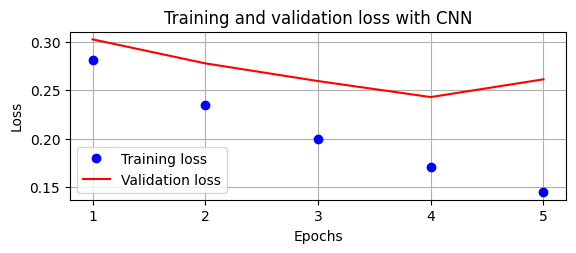

<ipython-input-13-7a9e3eea833f>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


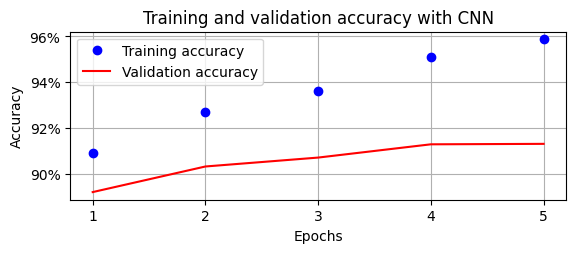

In [13]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

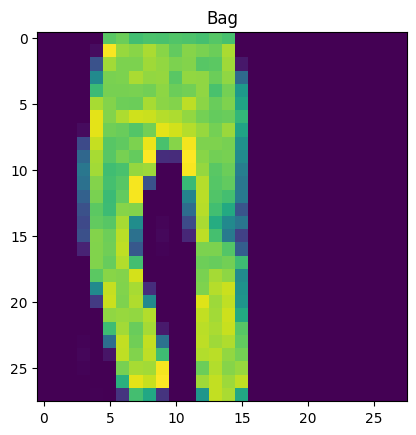

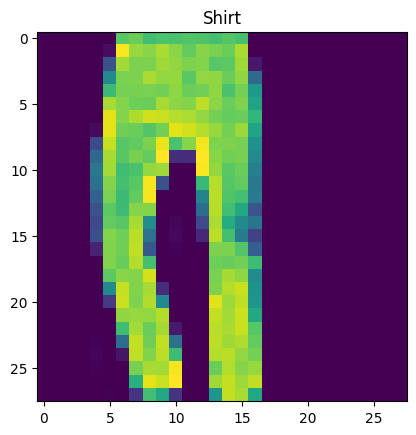

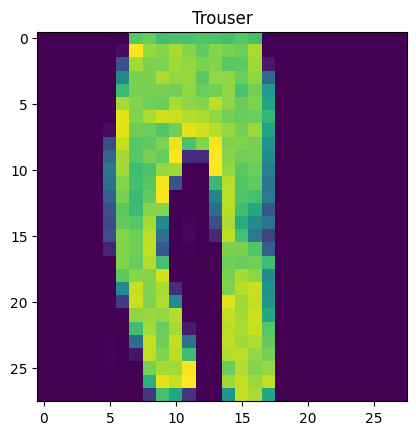

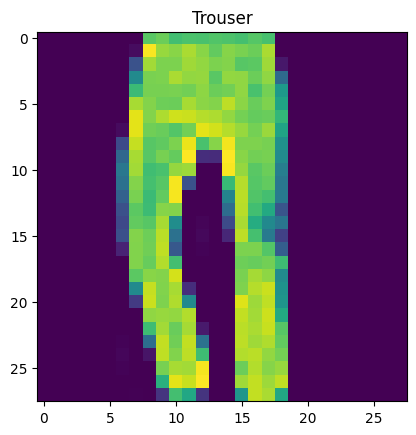

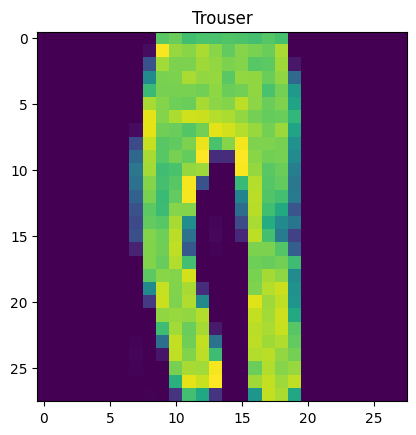

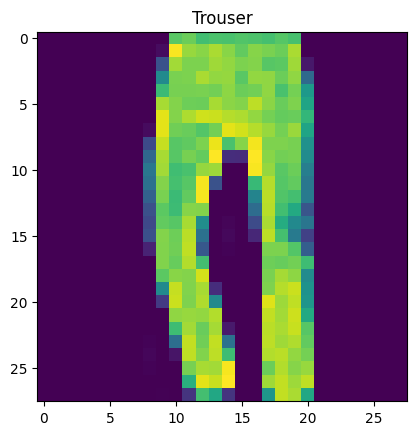

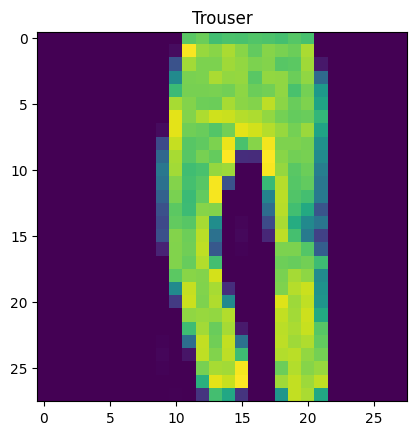

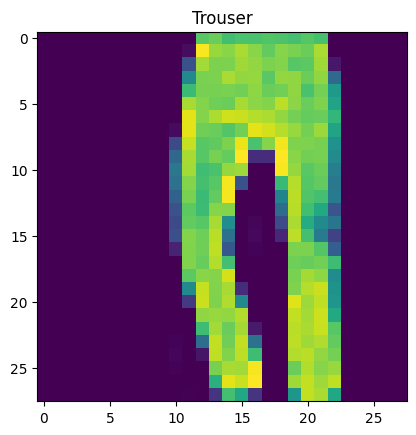

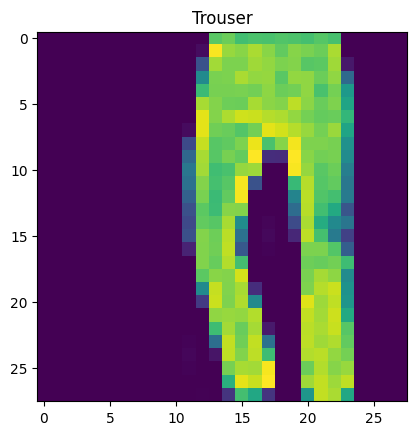

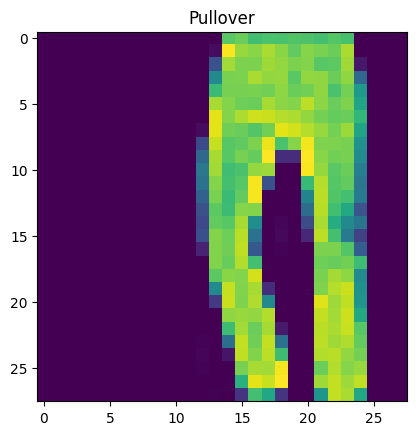

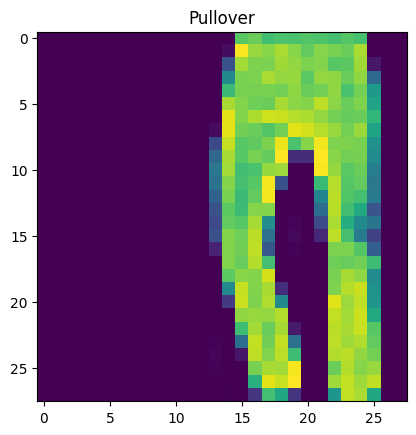

In [14]:
preds = []
ix = 24300
for px in range(-5,6):
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  img2 = np.roll(img, px, axis=1)
  img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  pred = np.exp(np_output)/np.sum(np.exp(np_output))
  preds.append(pred)
  plt.imshow(img2)
  plt.title(fmnist.classes[pred[0].argmax()])
  plt.show()

<Axes: title={'center': 'Probability of each class for various translations'}>

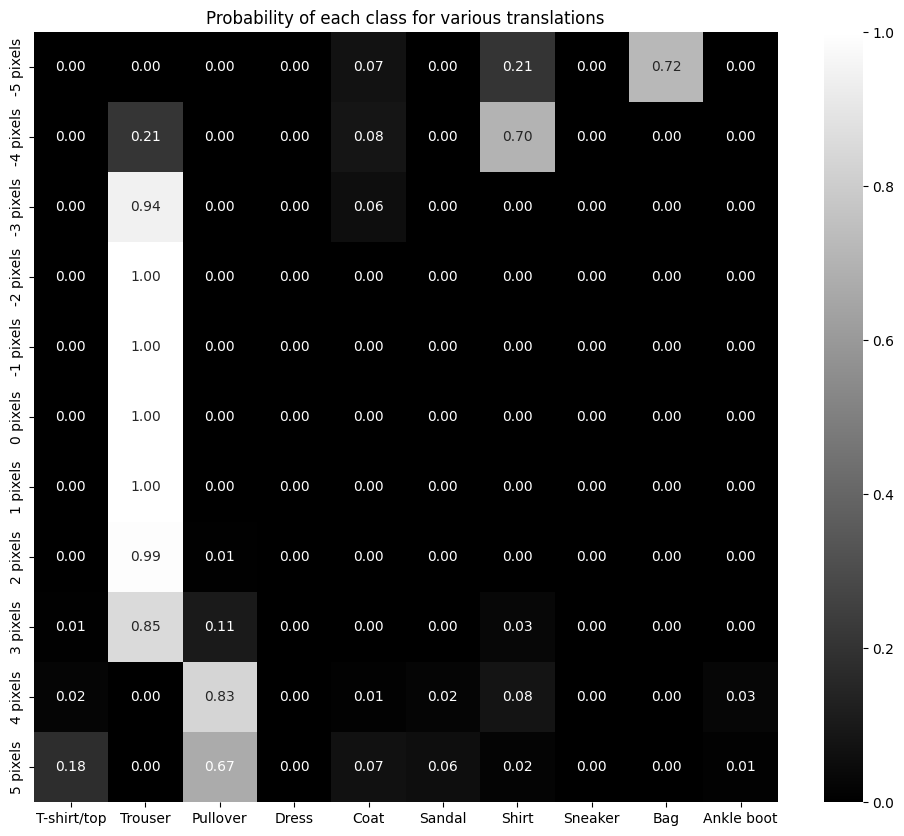

In [15]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')

# Building blocks of a CNN
CNNs are the most prominent architectures that are used when working on images. CNNs address the major limitations of deep neural networks that we saw in the previous section. Besides image classification, they also help with object detection, image segmentation, GANs, and many more – essentially, wherever we use images. Furthermore, there are different ways of constructing a convolutional neural network, and there are multiple pre-trained models that leverage CNNs to perform various tasks. Starting with this chapter, we will be using CNNs extensively.

In the upcoming subsections, we will understand the fundamental building blocks of a CNN, which are as follows:

- Convolutions
- Filters
- Strides and padding
- Pooling

A convolution is basically multiplication between two matrices. As you saw in the previous chapter, matrix multiplication is a key ingredient of training a neural network. (We perform matrix multiplication when we calculate hidden layer values – which is a matrix multiplication of the input values and weight values connecting the input to the hidden layer. Similarly, we perform matrix multiplication to calculate output layer values.)

To ensure we have a solid understanding of the convolution process, let's go through the following example.

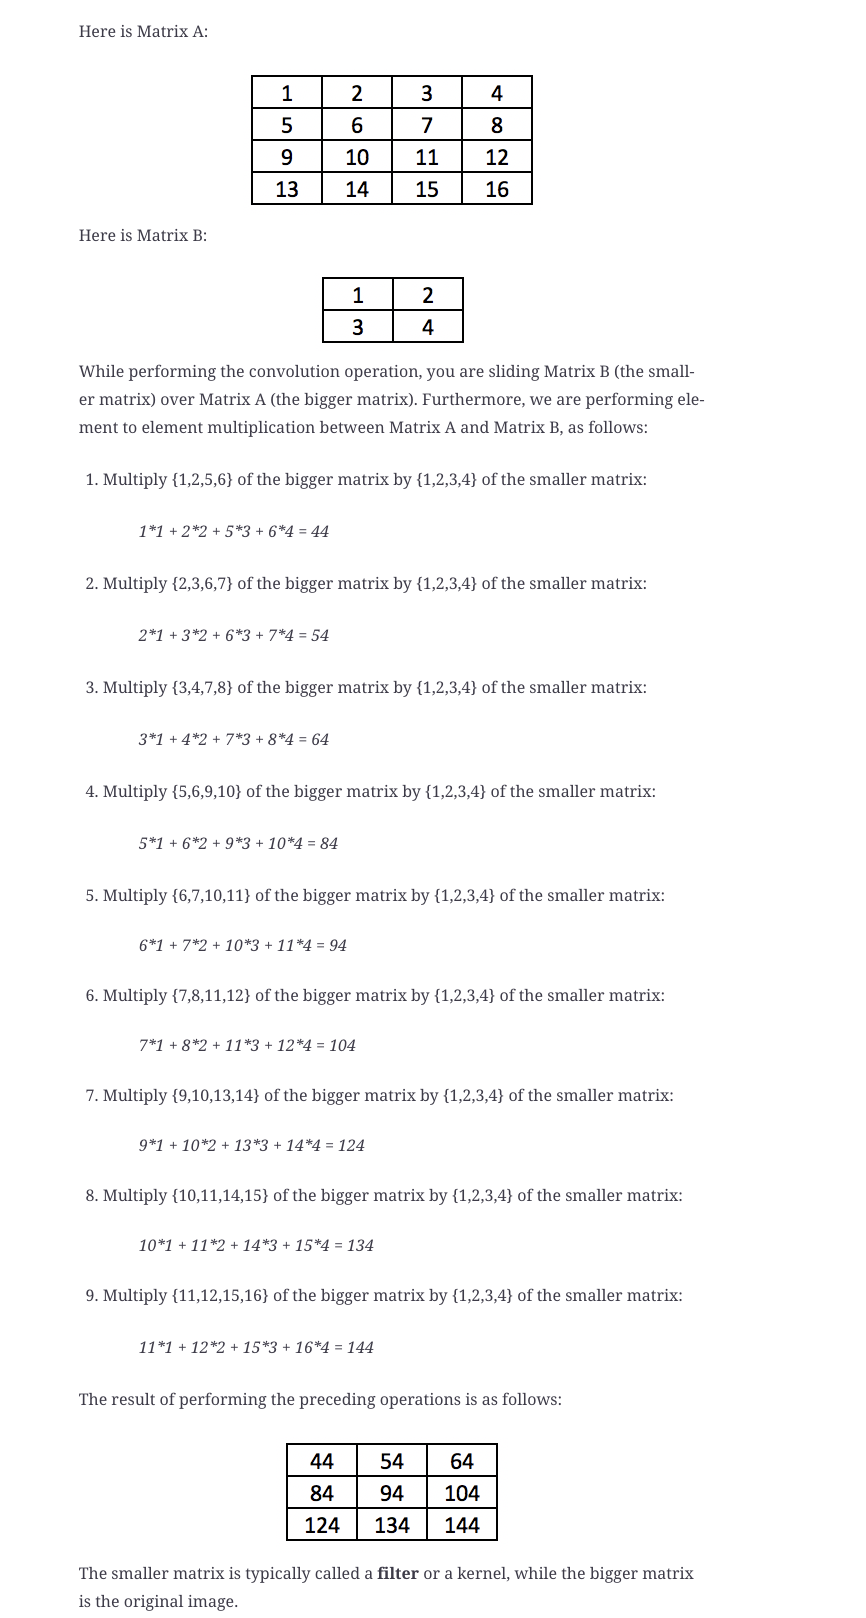

# Filter
A filter is a matrix of weights that is initialized randomly at the start. The model learns the optimal weight values of a filter over increasing epochs.

The concept of filters brings us to two different aspects:

What the filters learn about
How filters are represented
In general, the more filters there are in a CNN, the more features of an image that the model can learn about. We will learn about what various filters learn in the Visualizing the filters' learning section of this chapter. For now, we'll ensure that we have an intermediate understanding that the filters learn about different features present in the image. For example, a certain filter might learn about the ears of a cat and provide high activation (a matrix multiplication value) when the part of the image it is convolving with contains the ear of a cat.

In the previous section, we learned that when we convolved one filter that has a size of 2 x 2 with a matrix that has a size of 4 x 4, we got an output that is 3 x 3 in dimension.

However, if 10 different filters multiply the bigger matrix (original image), the result is 10 sets of the 3 x 3 output matrices.

In the preceding case, a 4 x 4 image is convolved with 10 filters that are 2 x 2 in size, resulting in 3 x 3 x 10 output values. Essentially, when an image is convolved by multiple filters, the output has as many channels as there are filters that the image is convolved with.
Furthermore, in a scenario where we are dealing with color images where there are three channels, the filter that is convolving with the original image would also have three channels, resulting in a single scalar output per convolution. Also, if the filters are convolving with an intermediate output – let's say of 64 x 112 x 112 in shape – the filter would have 64 channels to fetch a scalar output. In addition, if there are 512 filters that are convolving with the output that was obtained in the intermediate layer, the output post convolution with 512 filters would be 512 x 111 x 111 in shape.

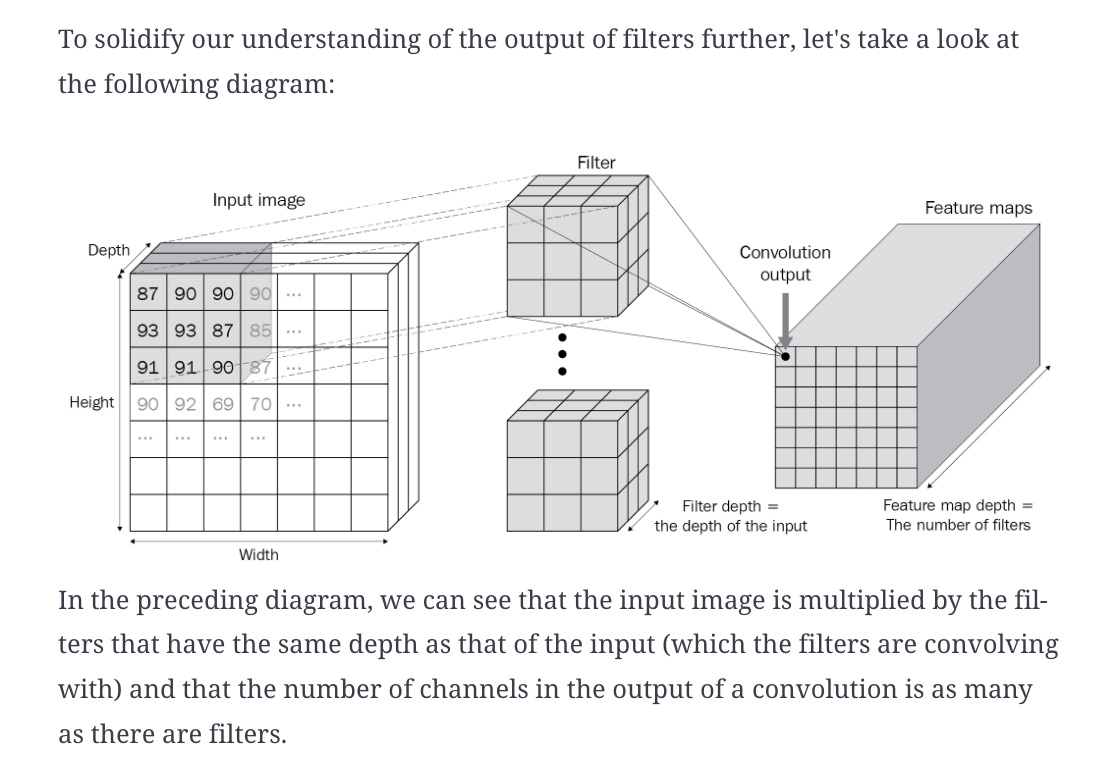

# Strides and padding


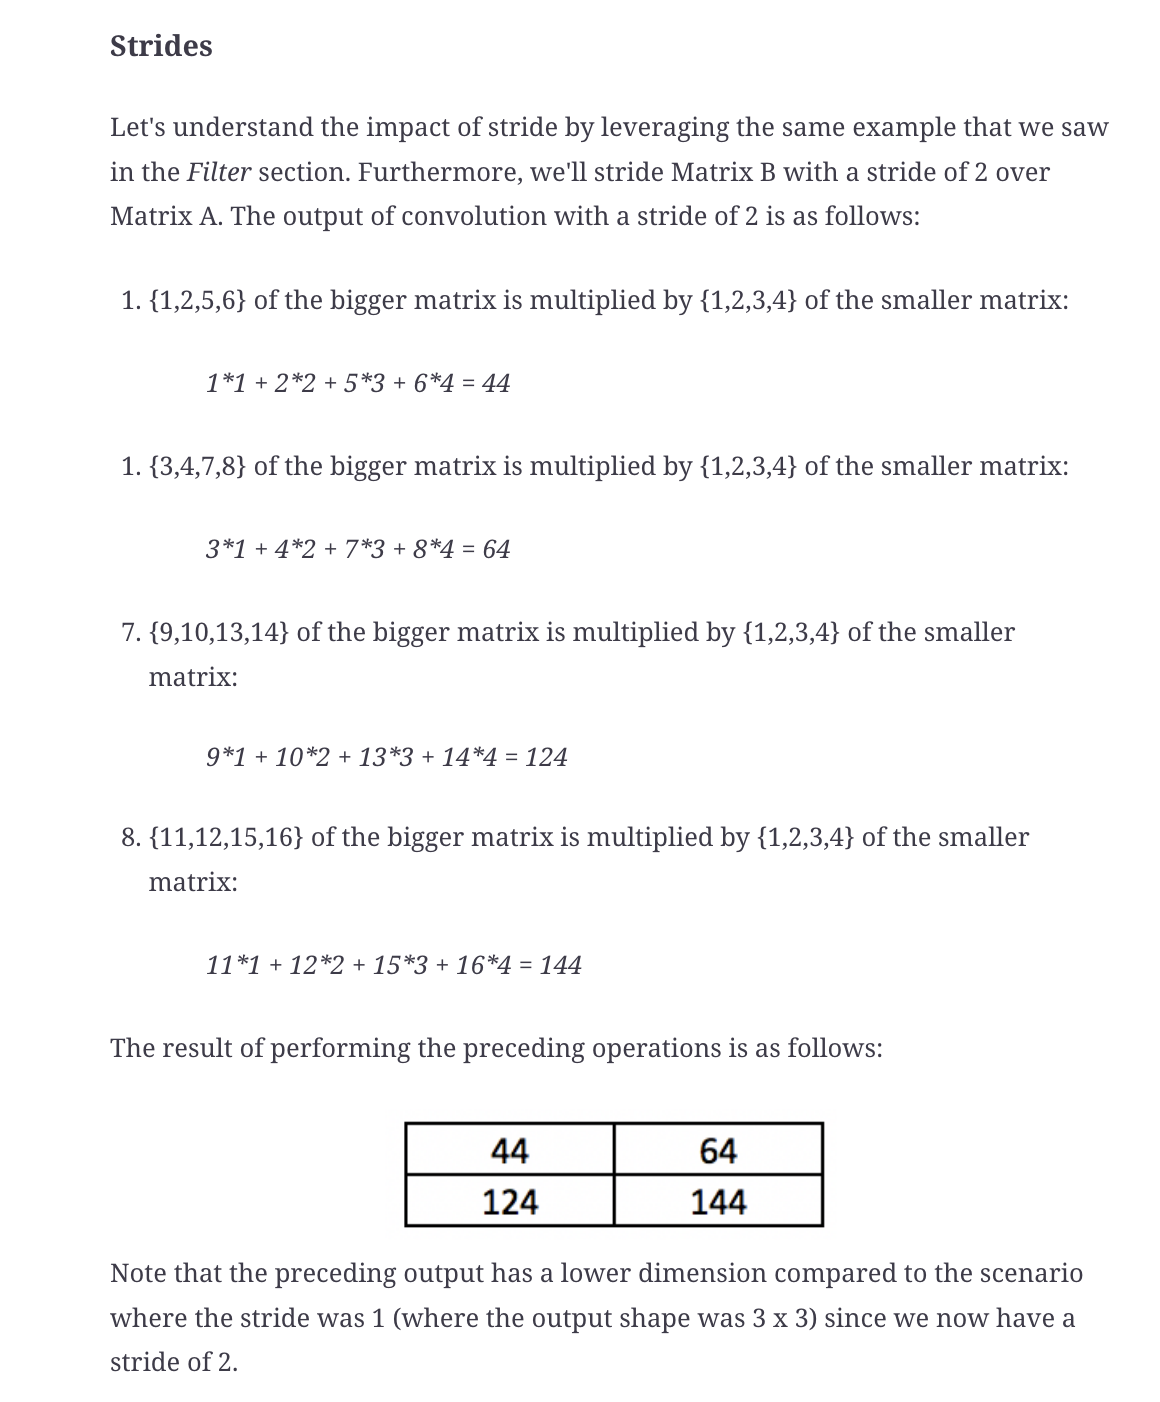

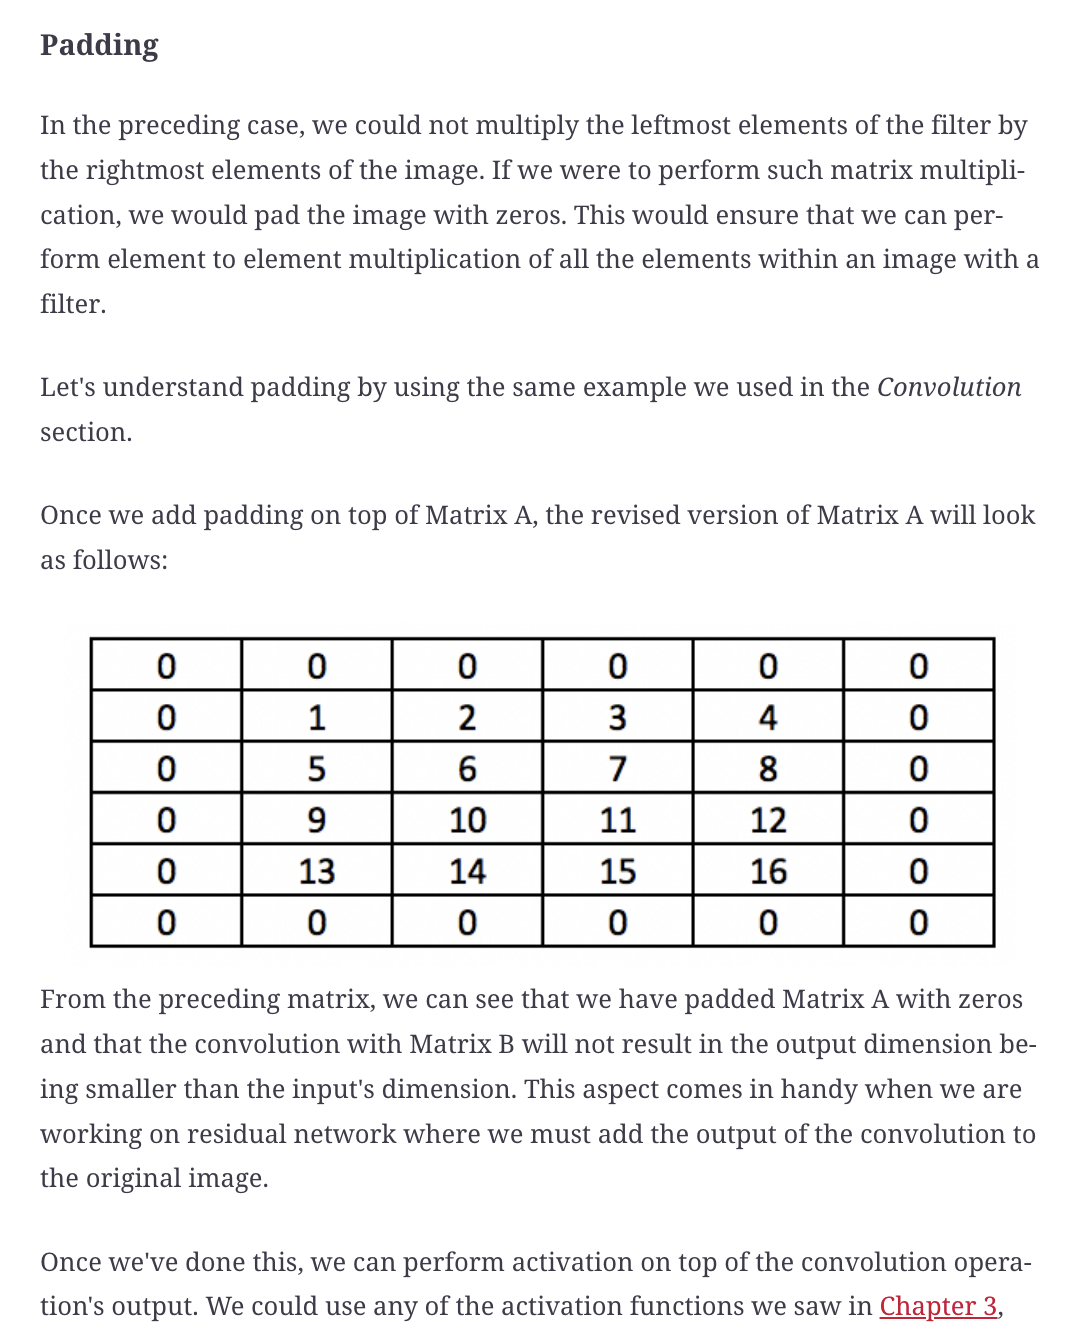

# Pooling 

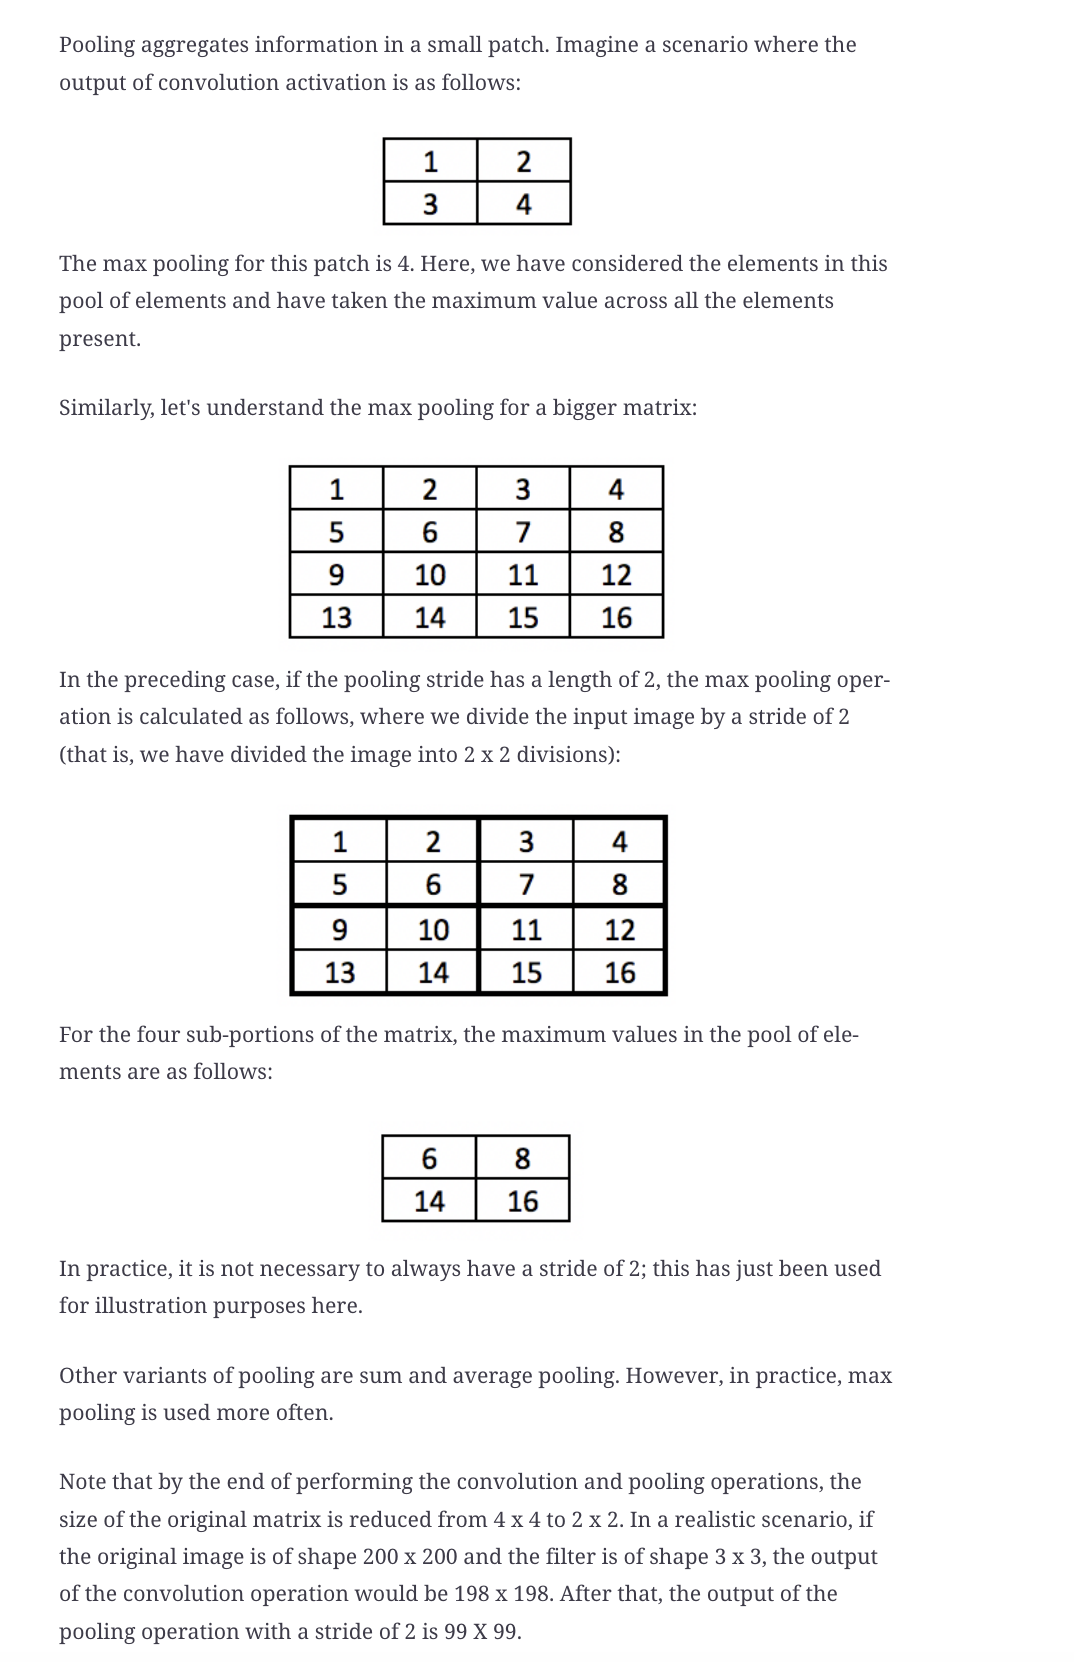

# Flattening Layer

To understand the flattening process, we'll take the output of the pooling layer in the previous section and flatten the output. The output of flattening the pooling layer is as follows:

{6, 8, 14, 16}

By doing this, we'll see that the flatten layer can be treated equivalent to the input layer (where we flattened the input image into a 784-dimensional input 

Once the flatten layer's (fully connected layer) values have been obtained, we can pass it through the hidden layer and then obtain the output for predicting the class of an image.

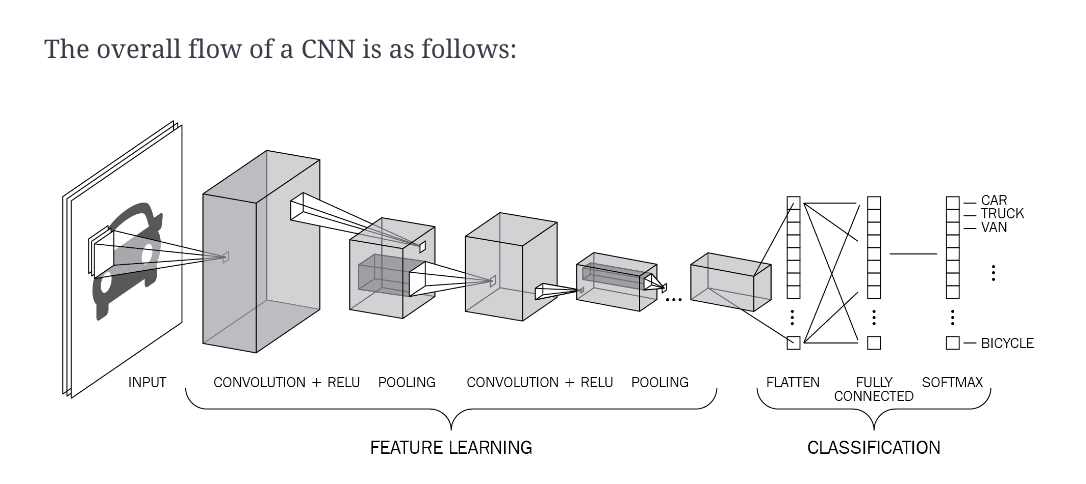

# SUMMARY

The operations of convolution and pooling constitute the feature learning section as filters help in extracting relevant features from images and pooling helps in aggregating information and thereby reducing the number of nodes at the flatten layer. (If we directly flatten the input image (which is 300 x 300 pixels in size, for example), we are dealing with 90K input values. If we have 90K input pixel values and 100K nodes in a hidden layer, we are looking at ~9 billion parameters, which is huge in terms of computation.)

Once we perform convolution, activation, and pooling on top of it, we'll have reduced the dimension of the image (due to pooling), which means that a fewer number of pixels store the majority of the information from the original image. Moreover, given that pooling stores information of a region (patch), the information within a pixel of the pooled image would not vary, even if the original image is translated by 1 unit. This is because the maximum value of that region is likely to get captured in the pooled image.

# Implementing data augmentation
In the previous scenario, we learned about how CNNs help in predicting the class of an image when it is translated. While this worked well for translations of up to 5 pixels, anything beyond that is likely to have a very low probability for the right class. In this section, we'll learn how to ensure that we predict the right class, even if the image is translated by a considerable amount.

To address this challenge, we'll train the neural network by translating the input images by 10 pixels randomly (both toward the left and the right) and passing them to the network. This way, the same image will be processed as a different image in different passes since it will have had a different amount of translation in each pass.



Image augmentations
So far, we have learned about the issues image translation can have on a model's prediction accuracy. However, in the real world, we might encounter various scenarios, such as the following:

- Images are rotated slightly
- Images are zoomed in/out (scaled)
- Some amount of noise is present in the image
- Images have low brightness
- Images have been flipped
- Images have been sheared (one side of the image is more twisted)

A neural network that does not take the preceding scenarios into consideration won't provide accurate results, just like in the previous section, where we had a neural network that had not been explicitly trained on images that had been heavily translated.

Image augmentations come in handy in scenarios where we create more images from a given image. Each of the created images can vary in terms of rotation, translation, scale, noise, and brightness. Furthermore, the extent of the variation in each of these parameters can also vary (for example, translation of a certain image in a given iteration can be +10 pixels, while in a different iteration, it can be -5 pixels).

The augmenters class in the imgaug package has useful utilities for performing these augmentations. Let's take a look at the various utilities present in the augmenters class for generating augmented images from a given image. Some of the most prominent augmentation techniques are as follows:

- Affine transformations
- Change brightness
- Add noise
Note that PyTorch has a handy image augmentation pipeline in the form of torchvision.transforms. However, we still opted to introduce a different library primarily because of the larger variety of options imgaug contains, as well as due to the ease of explaining augmentations to a new user. You are encouraged to research the torchvision transforms as an exercise and recreate all the functions that are presented to strengthen your understanding.

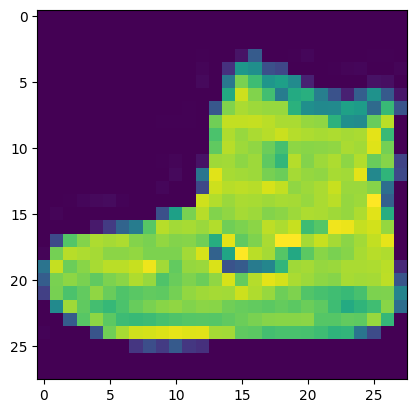

In [36]:
plt.imshow(tr_images[0])